- Verify that the outputs by the DSM model is correct - as in compare it to a random model of same shape
- Look at representations of learnt SAC Pendulum model? 
We want to understand Internal representations of the model, i.e, plotting internal activity of model acc to external states
For one neuron in the model (eg-dense layer 2  kernel) - 3D rate map - average activity based on input dimensions
Hypothesis - Different parts of model track diff things - one neuron may model velocity, one may track certain xy regions - Pendulum env


In [1]:
import contextlib
import inspect
import logging
import operator
import os
import sys
import typing
from typing import Any

import fancyflags as ff
import fiddle as fdl
import fiddle.extensions.jax
import jax
import jax.numpy as jnp
import numpy as np
import orbax.checkpoint
import tqdm.rich as tqdm
from absl import app, flags
from absl import logging as absl_logging
from clu import metric_writers
from dm_env import specs
from etils import epath
from fiddle import absl_flags as fdl_flags
from fiddle import printing
from fiddle.codegen import codegen
from fiddle.experimental import serialization
from flax import traverse_util

from dsm import configs, console, datasets, envs, metrics, plotting, stade, train
from dsm.state import State

_WORKDIR = epath.DEFINE_path("workdir", "logdir", "Working directory.")
_CHECKPOINT_FROM = flags.DEFINE_string(
    "checkpoint_from",
    None,
    "Checkpoint to load from, we'll only restore from this checkpoint if "
    "the checkpoint step is greater than the current step."
    "If not specified, will load from the latest checkpoint in the working directory.",
)
_PROFILE = flags.DEFINE_bool("profile", False, "Enable profiling.")


def _maybe_restore_state(checkpoint_manager: orbax.checkpoint.CheckpointManager, state: State) -> State:
    latest_step = checkpoint_manager.latest_step()

    def _restore_state(step: int, directory: os.PathLike[str] | None = None) -> State:
        print('Debug directory', directory)
        logging.info(f"Restoring checkpoint from {directory or checkpoint_manager.directory} at step {step}.")
        restored = checkpoint_manager.restore(
            step,
            {"generator": state.generator, "discriminator": state.discriminator},
            directory=os.path.abspath(directory or checkpoint_manager.directory),
        )
        [g_state, d_state] = operator.itemgetter("generator", "discriminator")(restored)
        return State(step=jnp.int32(step), generator=g_state, discriminator=d_state)

    if _CHECKPOINT_FROM.value and (checkpoint_steps := orbax.checkpoint.utils.checkpoint_steps(_CHECKPOINT_FROM.value)):
        logging.info(f"Found checkpoint directory {_CHECKPOINT_FROM.value} with steps {checkpoint_steps}.")
        latest_checkpoint_step = max(checkpoint_steps)
        if not latest_step or latest_checkpoint_step > latest_step:
            return _restore_state(latest_checkpoint_step, _CHECKPOINT_FROM.value)
    if latest_step:
        return _restore_state(latest_step)

    logging.info("No checkpoint found.")
    return state

jax.config.parse_flags_with_absl()


def _maybe_remove_absl_logger() -> None:
    if (absl_handler := absl_logging.get_absl_handler()) in logging.root.handlers:
        logging.root.removeHandler(absl_handler)


from dsm.state import FittedValueTrainState
import numpy.typing as npt
from dsm import datasets, plotting, rewards
from dsm.configs import Config
from dsm.plotting import utils as plot_utils


[12:20:06] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=641396;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\dm_control\_render\__init__.py\__init__.py]8;;\:]8;id=374757;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\dm_control\_render\__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=356126;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\dm_control\_render\__init__.py\__init__.py]8;;\:]8;id=648522;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\dm_control\_render\__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=256862;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\dm_control\mujoco\wrapper\mjbindings\__init__.py\__init__.py]8;;\:]8;id=162441;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\dm_control\mujoco\wrapper\mjbindings\__init__.py#31\31]8;;\

In [2]:
def compute_return_distribution(
    # compute_distribution_metrics
    state: FittedValueTrainState,
    rng: jax.Array,
    *,
    config: Config,
) -> tuple[dict[str, npt.NDArray], dict[str, float]]:
    policy = datasets.make_policy(config.env)

    dsm_returns = {}
    for reward_fn_name, reward_fn in getattr(rewards, config.env).items():
        logging.info(f"Computing distribution metrics for {config.env} reward function {reward_fn_name}")
        for _stuff, source in zip(*plotting.source_states(config.env)):
            jax.debug.print("DEBUG DISTR METRICS Source {bar}", bar=source)
            jax.debug.print("DEBUG DISTR METRICS Stuff {bar}", bar=_stuff)
            dsr_return_distribution = plot_utils.return_distribution(
                state,
                rng,
                source,
                policy=policy,
                reward_fn=reward_fn,
                num_samples=config.plot_num_samples,
                config=config,
            )
            # jax.debug.print("DEBUG DISTR METRICS Rewards {bar}", bar=reward_fn_name)
            # jax.debug.print("DEBUG DISTR METRICS Source {bar}", bar=source)
            # jax.debug.print("DEBUG DISTR METRICS dsr_return_distribution {bar}", bar=dsr_return_distribution)
            
            if reward_fn_name not in dsm_returns:
                dsm_returns[reward_fn_name] = [dsr_return_distribution.tolist()]
            else:
                dsm_returns[reward_fn_name].extend(dsr_return_distribution.tolist())
                
    return dsm_returns

In [3]:
# buildable from config
fiddle.extensions.jax.enable()

logging.getLogger("jax").setLevel(logging.INFO)
jax.config.update("jax_numpy_rank_promotion", "raise")

# from absl.flags import FLAGS, define_string
# define_string('fdl_config', None, 'The Fiddle configuration to use.')
# define_string('fdl_config_file', None, 'Path to the Fiddle configuration file.')

import fiddle.absl_flags as fdl_flags
FLAGS = flags.FLAGS
# flags.DEFINE_string('fdl_config', 'base', 'The Fiddle configuration to use.')
if not FLAGS.fdl_config and not FLAGS.fdl_config_file:
        FLAGS.fdl_config = 'base'
# _maybe_remove_absl_logger()
buildable = fdl_flags.create_buildable_from_flags(configs)


In [4]:
# checkpoint manager
logging.info(printing.as_str_flattened(buildable))
config: configs.Config = fdl.build(buildable)

workdir: epath.Path = _WORKDIR.value
workdir.mkdir(parents=True, exist_ok=True)

jax.debug.print("DEBUG directory {bar}", bar=os.path.abspath(workdir))
checkpoint_manager = orbax.checkpoint.CheckpointManager(
os.path.abspath(workdir),
checkpointers={
        "generator": orbax.checkpoint.PyTreeCheckpointer(),
        "discriminator": orbax.checkpoint.PyTreeCheckpointer(),
},
options=orbax.checkpoint.CheckpointManagerOptions( max_to_keep=2, enable_async_checkpointing=False, async_options=None,create=True, ),
)

[12:20:07] INFO     seed: int = 0                                                                   ]8;id=786569;file://C:\Users\sruth\AppData\Local\Temp\ipykernel_11528\2127111353.py\2127111353.py]8;;\:]8;id=596645;file://C:\Users\sruth\AppData\Local\Temp\ipykernel_11528\2127111353.py#2\2]8;;\
                    env: typing.Literal['Pendulum-v1', 'WindyGridWorld-v0',                                        
                    'WindyGridWorld-top-v0', 'WindyGridWorld-bottom-v0'] = 'Pendulum-v1'                           
                    generator: typing.Annotated[flax.linen.module.Module, dsm.tags.Generator] =                    
                    <Config[MLP(                                                                                   
                      num_layers=3,                                                                                
                      num_hidden_units=256,                                                                        
                      dtype[#dsm.tags.DType]=<class 'jax.numpy.float32'>,                                          
                      param_dtype[#dsm.tags.DType]=<class 'jax.numpy.float32'>)]>                                  
                    #dsm.tags.Generator                                                                            
                    generator_optim: typing.Annotated[optax._src.base.GradientTransformation,                      
                    dsm.tags.Generator] = <Config[adam(                                                            
                      learning_rate[#dsm.tags.Generator, #dsm.tags.LearningRate]=6.25e-05,                         
                      eps=0.00015)]> #dsm.tags.Generator                                                           
                    discriminator: typing.Annotated[flax.linen.module.Module,                                      
                    dsm.tags.Discriminator] = <Config[SpectralNorm(                                                
                      layer_instance=<Config[ResidualMLP(                                                          
                        num_hidden_units=256,                                                                      
                        num_layers_per_block=2,                                                                    
                        num_blocks=2,                                                                              
                        num_outputs=2,                                                                             
                        dtype[#dsm.tags.DType]=<class 'jax.numpy.float32'>,                                        
                        param_dtype[#dsm.tags.DType]=<class 'jax.numpy.float32'>)]>,                               
                      collection_name='spectral_norm')]> #dsm.tags.Discriminator                                   
                    discriminator_optim: typing.Annotated[optax._src.base.GradientTransformation,                  
                    dsm.tags.Discriminator] = <Config[adam(                                                        
                      learning_rate[#dsm.tags.Discriminator, #dsm.tags.LearningRate]=6.25e-05,                     
                      eps=0.00015)]> #dsm.tags.Discriminator                                                       
                    dtype: dtype = <class 'jax.numpy.float32'> #dsm.tags.DType                                     
                    inner_kernel.bandwidths: tuple[float, ...] = (0.2, 0.5, 1.0, 2.0, 5.0)                         
                    inner_kernel_adaptive_bandwidth: bool = False                                                  
                    inner_linear_kernel: bool = False                                                              
                    inner_separate_discriminator: bool = False                                      

DEBUG directory c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\logdir


           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=74904;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\orbax\checkpoint\checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=949105;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\orbax\checkpoint\checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'cuda':                                          ]8;id=142847;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\jax\_src\xla_bridge.py\xla_bridge.py]8;;\:]8;id=340090;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\jax\_src\xla_bridge.py#660\660]8;;\

           INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no     ]8;id=747169;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\jax\_src\xla_bridge.py\xla_bridge.py]8;;\:]8;id=234614;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\jax\_src\xla_bridge.py#660\660]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not      ]8;id=982582;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\jax\_src\xla_bridge.py\xla_bridge.py]8;;\:]8;id=385331;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\jax\_src\xla_bridge.py#660\660]8;;\
                    implemented on windows yet.                                                                    

In [5]:
env = envs.make(config.env)
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
rng = np.random.default_rng(config.seed)

data = datasets.make_dataset(config.env)

rng_key = jax.random.PRNGKey(rng.integers(np.iinfo(np.int64).min, np.iinfo(np.int64).max))
rng_key, state_rng_key = jax.random.split(rng_key)

# for checkpointing
state = train.make_state(state_rng_key, typing.cast(specs.DiscreteArray, env.observation_spec()), config)
state = _maybe_restore_state(checkpoint_manager, state)
print('Saved model state: ')

def print_params_shapes(params: Any, prefix: str = ""):
        if isinstance(params, dict):
                for key, value in params.items():
                        print_params_shapes(value, f"{prefix}.{key}" if prefix else key)
        elif isinstance(params, (jax.Array, jnp.ndarray)):
                print(f"{prefix}: {params.shape}")
        else:
                print(f"{prefix}: {type(params)}")
print("Generator params shapes:")
print_params_shapes(state.generator.params)
print("\nDiscriminator params shapes:")
print_params_shapes(state.discriminator.params)

def print_main_keys(obj):
        keys = vars(obj).keys()
        print("\nMain keys of state:")
        for key in keys:
                print(key)
print_main_keys(state)

Debug directory None


[12:20:10] INFO     Restoring checkpoint from                                                       ]8;id=888541;file://C:\Users\sruth\AppData\Local\Temp\ipykernel_11528\343736010.py\343736010.py]8;;\:]8;id=586738;file://C:\Users\sruth\AppData\Local\Temp\ipykernel_11528\343736010.py#48\48]8;;\
                    c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\logdir at                   
                    step 1500.                                                                                     

           INFO     Restoring item from                                                         ]8;id=171358;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\orbax\checkpoint\checkpointer.py\checkpointer.py]8;;\:]8;id=224416;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\orbax\checkpoint\checkpointer.py#164\164]8;;\
                    c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\logdir\1                    
                    500.                                                                                           

c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\orbax\checkpoint\type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=974497;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\orbax\checkpoint\checkpointer.py\checkpointer.py]8;;\:]8;id=959156;file://c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\.venv\lib\site-packages\orbax\checkpoint\checkpointer.py#167\167]8;;\
                    c:\Users\sruth\Documents\UCL\A_Thesis_main\codes\distributional-sr\logdir\1                    
                    500.                                                                                           

Saved model state: 
Generator params shapes:
params.model.Dense_0.bias: (16, 256)
params.model.Dense_0.kernel: (16, 5, 256)
params.model.Dense_1.bias: (16, 256)
params.model.Dense_1.kernel: (16, 256, 256)
params.model.Dense_2.bias: (16, 256)
params.model.Dense_2.kernel: (16, 256, 256)
params.model.Dense_3.bias: (16, 3)
params.model.Dense_3.kernel: (16, 256, 3)

Discriminator params shapes:
model.layer_instance.Dense_0.bias: (256,)
model.layer_instance.Dense_0.kernel: (3, 256)
model.layer_instance.Dense_1.bias: (2,)
model.layer_instance.Dense_1.kernel: (256, 2)
model.layer_instance.MLP_0.Dense_0.bias: (256,)
model.layer_instance.MLP_0.Dense_0.kernel: (256, 256)
model.layer_instance.MLP_0.Dense_1.bias: (256,)
model.layer_instance.MLP_0.Dense_1.kernel: (256, 256)
model.layer_instance.MLP_0.Dense_2.bias: (256,)
model.layer_instance.MLP_0.Dense_2.kernel: (256, 256)
model.layer_instance.MLP_1.Dense_0.bias: (256,)
model.layer_instance.MLP_1.Dense_0.kernel: (256, 256)
model.layer_instance.MLP_

In [6]:
dir(state.generator)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__dataclass_transform__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_flax_dataclass',
 'apply_fn',
 'apply_gradients',
 'create',
 'metrics',
 'opt_state',
 'params',
 'replace',
 'step',
 'target_params',
 'target_params_update',
 'tx']

In [7]:
# print_main_keys(state.generator)  
# #step, apply_fn,apply_gradients, params, tx, opt_state, target_params, target_params_update, metrics 
# target_params_update=SoftTargetParamsUpdate(step_size=0.01), 
# metrics=_InlineCollection(
#       _reduction_counter=_ReductionCounter(value=Array(501, dtype=int32)), 
#       mmd=Metric.from_output.<locals>.FromOutput(total=Array(25.586227, dtype=float32), count=Array(500, dtype=int32)), 
#       observation=Metric.from_output.<locals>.FromOutput(total=Array(154.22746, dtype=float32), count=Array(500, dtype=int32)), 
#       embedding=Metric.from_output.<locals>.FromOutput(total=Array(507.3972, dtype=float32), count=Array(500, dtype=int32))))

print(state.generator.params['params']['model'].keys())
# ['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])

print(state.generator.params['params']['model']['Dense_3']['kernel'].shape)

dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
(16, 256, 3)


In [8]:
# dsm_returns = compute_return_distribution(
#         state.generator, jax.random.PRNGKey(0), config=config
#     )

#adapted from compute_return_distribution code

def compute_DSM_samples(
    # compute_distribution_metrics
    state: FittedValueTrainState,
    rng: jax.Array,
    *,
    config: Config,
    source_state: list[float],
): 
#-> tuple[dict[str, npt.NDArray], dict[str, float]]:
    
    # for _stuff, source in zip(*saved_source_states):
    #     jax.debug.print("DEBUG DISTR METRICS Source {bar}", bar=source)
    #     jax.debug.print("DEBUG DISTR METRICS Stuff {bar}", bar=_stuff)
    # code from plot_utils.return_distribution
    'TAKING SINGLE SOURCE STATE FOR NOW'
    jax.debug.print("Selected Source {bar}", bar=source_state)
    num_samples=config.plot_num_samples # Number of state samples 
    num_outer=config.num_outer # Number of model atoms   
    num_latent_dims=config.latent_dims # Dimension of input noise 
    print('num_samples', num_samples,' num_outer:', num_outer, ' num_latent_dims ',num_latent_dims)
    'Simulating trajectories in an MDP'
    #Code from plot_utils.sample_from_sr # samples = plot_utils.sample_from_sr(...)
    # generates samples from the state representation - Generates samples from the model using the provided source state and configuration settings
    # source_state is used to create a context for sampling by repeating it across the number of samples and outer dimensions
    import einops
    zs = jax.random.normal(rng, (num_samples, num_outer, num_latent_dims))
    context = einops.repeat(source_state_current, "s -> i o s", i=num_samples, o=num_outer)
    xs = jnp.concatenate((zs, context), axis=-1)
    ys = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, xs)
    samples =  einops.rearrange(ys, "i o s -> o i s")
    print(samples.shape) #num_outer, num_samples, 3
    # print(samples[-1])
    
    #thetas = np.arctan2(samples[i, :, 1], samples[i, :, 0]) % (2 * np.pi)
    # velocities = samples[i, :, -1]
    return source_state_current, samples


saved_source_states = plotting.source_states(config.env) 
# has 2 lists of 9 elements each - each element is a list of 2 elements  - states:[theta, thetadot] observations: [sin(theta), cos(theta), thetadot]
# print('DEBUG source states 0 - polar coords, angular velocity',saved_source_states[0]) 
# print('DEBUG source states 1 - cartesian coords, angular velocity',saved_source_states[1])
sources_all = saved_source_states[1]
source_state_current = sources_all[0]
    
source, samples = compute_DSM_samples(
        state.generator, jax.random.PRNGKey(0), config=config, source_state=source_state_current,
    )

Selected Source [ 6.123234e-17  1.000000e+00 -4.000000e+00]
num_samples 32  num_outer: 16  num_latent_dims  2
(16, 32, 3)


In [13]:
# plotting generated samples
import matplotlib.pyplot as plt
from dsm.plotting import utils as plotting_utils

def plot_samples(samples):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6 * 2, 6))
    # # Left scatter plot
    # # converts Cartesian coordinates to polar coordinates (thetas) and extracts velocities
    ENVIRONMENT = "Pendulum-v1"
    from dsm import datasets
    dataset = datasets.make_dataset(ENVIRONMENT)
    thetas = np.arctan2(dataset.observation[:, 1], dataset.observation[:, 0]) % (2 * np.pi)
    velocities = dataset.observation[:, -1]
    axs[0].scatter(thetas, velocities, alpha=0.1, s=1.0, color="grey")

    # fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    # Plot atom scatter & kde
    # plots generated samples - each colour represents atom?
    print('DEBUG plot_samples() - atoms? - samples.shape[0]',samples.shape[0])
    cmap = plt.get_cmap("Dark2")  # pyright: ignore
    for i in range(samples.shape[0]):
        thetas = np.arctan2(samples[i, :, 1], samples[i, :, 0]) % (2 * np.pi)
        velocities = samples[i, :, -1]
        try:
            axs[1].scatter(thetas, velocities, color=cmap(i), s=2.0, alpha=0.25)
        except:
            plt.scatter(thetas, velocities, color=cmap(i), s=2.0, alpha=0.25)


    # Plot source state
    theta = np.arctan2(source[1], source[0]) % (2 * np.pi)
    try:
        for ax in axs:
            ax.scatter(theta, source[-1], marker="x", s=64, alpha=0.8, color="red")
    except:
        plt.scatter(theta, source[-1], marker="x", s=64, alpha=0.8, color="red")

    # set bounds
    try:
        for ax in axs:
            # ax.set_ylim(-8.5, 8.5)
            ax.set_aspect("auto")
            ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
    except:
        # plt.set_ylim(-8.5, 8.5)
        plt.xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])

    image = plotting_utils.fig_to_ndarray(fig)
    plt.show(fig)

Selected Source [ 6.123234e-17  1.000000e+00 -4.000000e+00]
num_samples 32  num_outer: 16  num_latent_dims  2
(16, 32, 3)
DEBUG plot_samples() - atoms? - samples.shape[0] 16


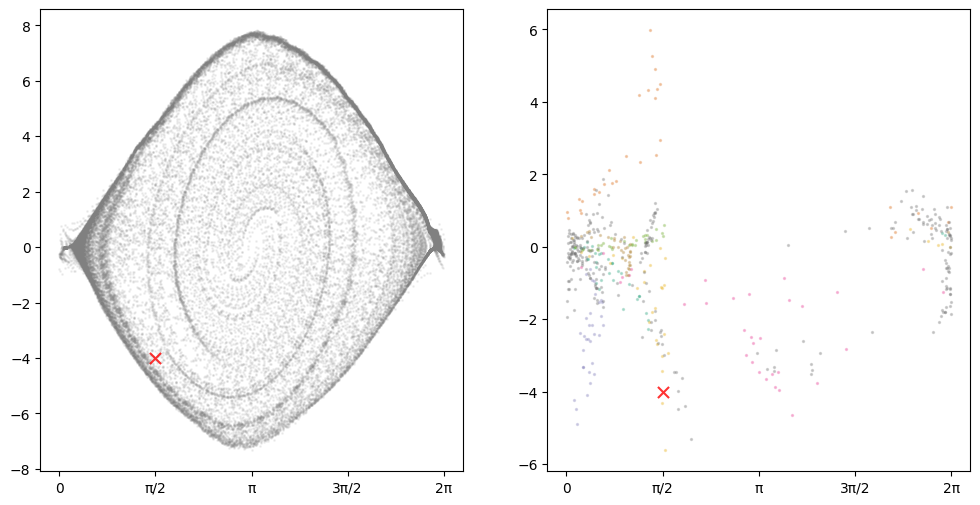

In [14]:
source_state_current = sources_all[0]
    
source, samples = compute_DSM_samples(
        state.generator, jax.random.PRNGKey(0), config=config, source_state=source_state_current,
    )
plot_samples(samples)

Selected Source [-1.8369702e-16 -1.0000000e+00  4.0000000e+00]
num_samples 32  num_outer: 16  num_latent_dims  2
(16, 32, 3)
DEBUG plot_samples() - atoms? - samples.shape[0] 16


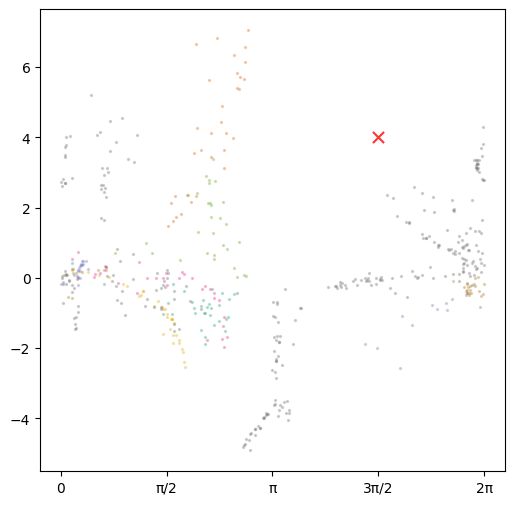

In [11]:
source_state_current = sources_all[-1]
    
source, samples = compute_DSM_samples(
        state.generator, jax.random.PRNGKey(0), config=config, source_state=source_state_current,
    )
plot_samples(samples)